# Ejercicio 2
En este notebook se busca encontrar la distribución de probabilidad del primer momento de falla en el caso de que el proceso sea regenerativo. Para ello se toma el código que entregó el profesor para simular el proceso y se tratará de aplicar el conteo de los pasos que superan el umbral y descartar los que ya lo hicieron en el primer momento.

Además, se deben contar los procesos que pasan por el umbral en un instante dado, y a partir de eso se debe calcular la distribución de probabilidad. Teniendo en cuenta los que pasaron por primera vez para la segunda pasada.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
import time

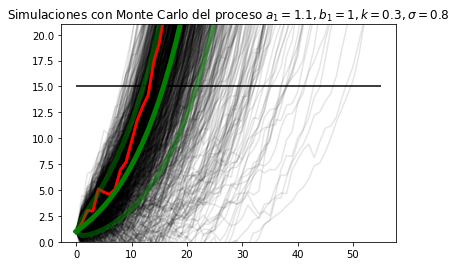

0.994 1000


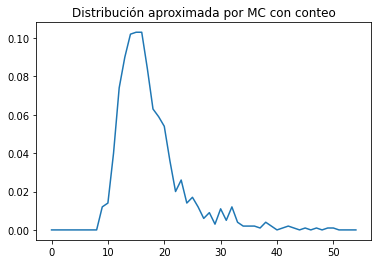

In [55]:
# primero se crea el proceso

x_0 = 1
N = 55

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.1
b1 = 1
sigma = 0.8
np.random.seed(32)
u = 15
K = 0.3

# definicion de las iteraciones de MC
M = 1000
PROCESOS = np.zeros((N,M))
PROCESOS[0, :] = x_0
np.random.seed(42)

cuentas = np.zeros((M,))
histogram_MC = np.zeros((N,))

I, J = [13, 50]

# media y varianza analiticas
E = np.zeros((N,))
Var = np.zeros((N,))

E[0] = proceso[0]

for i in range(I):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas)
    checkeo = PROCESOS[i, :] > u
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2
    

for i in range(I, J):
    proceso[i + 1] = K + a1 * b1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * b1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))

    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = PROCESOS[i, :] > u
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    
    # media y varianza
    E[i + 1] = K + a1 * b1 * E[i]
    Var[i + 1] = a1 ** 2 * b1 ** 2 * Var[i] + sigma**2

for i in range(J, int((N-1))):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = PROCESOS[i, :] > u
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2

histogram_MC = histogram_MC / M
plt.plot(PROCESOS, color='k', alpha=0.1)
plt.plot(proceso, color='r', lw=3)
plt.plot(E, color='g', lw=5)
plt.plot(E - np.sqrt(Var), color='g', lw=5, alpha=0.5)
plt.plot(E + np.sqrt(Var), color='g', lw=5, alpha=0.5)
plt.hlines(u,0,N)
plt.ylim(top=u*1.4, bottom=0)
plt.title('Simulaciones con Monte Carlo del proceso $a_1={}, b_1={}, k={}, \sigma={}$'.format(a1,b1,K,sigma))
plt.show()

print(np.sum(histogram_MC), M)
plt.plot(histogram_MC)
plt.title('Distribución aproximada por MC con conteo')
plt.show()

Se pretende simular el filtro de partículas hecho por Francisco

Este filtro requiere calcular de forma analítica (con el modelo del ruido) la media y la varianza del proceso. Luego hay que muestrear la pdf que se produce y sacar los puntos de esa pdf que pasen sobre el umbral.

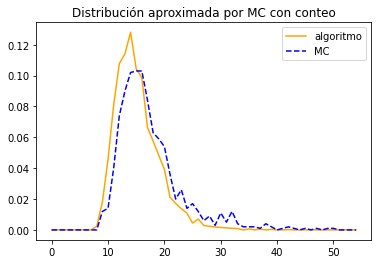

In [56]:
m = 100 # muestras de la pdf
fpt = np.zeros((N,))
ya_pasaron = np.ones((m,), dtype=int)

for i in range(1, N):
    # generar pdf
    x = np.linspace(E[i] - 3 * np.sqrt(Var[i]), E[i] + 3 * np.sqrt(Var[i]), num=m)
    PDF = norm.pdf(x, loc=E[i], scale=np.sqrt(Var[i]))
    
    aux = [PDF[j]*ya_pasaron[j] if x_ > u else 0 for j, x_ in enumerate(x)]
    ya_pasaron[x > u] = 0
#     print(ya_pasaron)
    fpt[i] = np.sum(aux)
    
    # plotear pdf
#     plt.plot(x[ya_pasaron == 1], PDF[ya_pasaron == 1], '.b')
#     plt.plot(x[ya_pasaron == 0], PDF[ya_pasaron == 0], '.r')
#     plt.vlines(u,0,np.max(PDF))
#     plt.xlim(0, 40)
#     fname = 'image_{}.png'.format(i)
#     plt.savefig(fname)
#     plt.show()

plt.plot(fpt / np.sum(fpt), color='orange', label='algoritmo')
# print(np.sum(histogram_MC), M)
plt.plot(histogram_MC, 'b--', label='MC')
plt.legend()
plt.title('Distribución aproximada por MC con conteo')
plt.show()

Ahora se calculará la distribución de probabilidad con el método utilizado en el paper de FPT. Lo complejo de este paso es que el cálculo de la matriz es complejo y cambiará según el intervalo en que se encuentre. Ahora, como ya se calculó la media y la varianza de cada uno de los momentos, debería ser más fácil calcular los elementos de la matriz.

In [57]:
# se definen las funciones para calcular la esperanza y la varianza en tiempo dado y dada una condicion
# inicial conocida
def E_(t, dt, x_=None):
    x = 0

    for i in range(dt):
        if t + i >= I and t + i < J: x += b1**(i - (I - t)) * a1**i
        else: x += a1**i
    x *= K
    
    if x_ is not None: x += (a1**dt) * x_
    else: x += (a1**dt) * proceso[t]
    
    return x

def Var_(t, dt, x_=None):
    x = 0
    
    for i in range(dt):
        if t + i >= I and t + i < J: x += a1**(2*(i - (I - t))) * b1**(2*(i - (I - dt)))
        else: x += a1**(2*i)
        
    
    x *= sigma**2
    
    return x


0.44

<ipython-input-58-9fe82e8851cd>:36: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = integrate.quad(integrand, u, np.inf, args=(0, i, j), epsabs=1,


0.98
 0.0

 1.8935707868198477


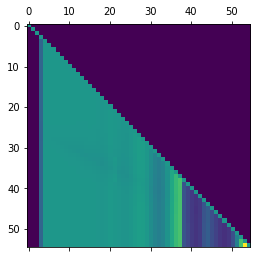

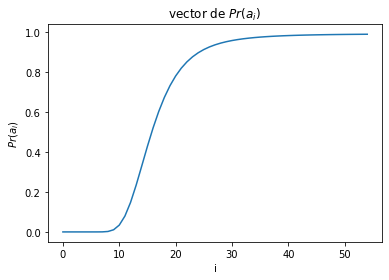

In [58]:
### DEFINICION DE INTEGRANDO PARA CALCULO DE THETA ###
def integrand(x, n, i, j):

    aux = norm.pdf( x , loc=E[j], scale=np.sqrt(Var[j] )) # bien
    
    aux *= 1 - norm.cdf(u, loc=E_(i, i - j, x), scale=np.sqrt(Var_(i, i - j, x)) )
    return aux


### CALCULO DE DISTRIBUCION DE ACUERDO AL PAPER ###
k = N ######################### cantidad de iteraciones
A = np.zeros((k,)) ################ vector de Pr(a)
theta = np.zeros((k,k)) ########### matriz theta
theta[0,0] = 1

for i in range(1,k):
    
    A[i] = 1 - norm.cdf(u, loc=E[i], scale=np.sqrt(Var[i])) # bien
    
    theta[i, i] = 1
    print('\r{:.2f}'.format(i/k), end='', flush=True)
    
    for j in range(1,i): # i,j
        
        aux = 1 - norm.cdf(u, loc=E[j], scale=np.sqrt(Var[j]))
        
#         print(aux)
        ### se agrega para que no colapse el calculo, ya que si la probabilidad es nula
        ## el valor final tambien debe ser nulo, solo en el caso de que realmente sea nulo
        # fix
        if aux == 0:
            theta[i, j] = 0
        else:
            theta[i, j] = 1 / aux
            # este metodo se debe aproximar por un calculo discreto
            integral = integrate.quad(integrand, u, np.inf, args=(0, i, j), epsabs=1,
                                      epsrel=1, limit=3, limlst=3)
#             print(integral)
            theta[i, j] *= integral[0]
#             theta[i, j] = 1
            
print('\n',np.min(theta))
print('\n',np.max(theta))
plt.matshow(theta)
plt.show()
plt.plot(A), plt.title('vector de $Pr(a_i)$'), plt.ylabel('$Pr(a_i)$'), plt.xlabel('i')
plt.show()

0.9961227631495705


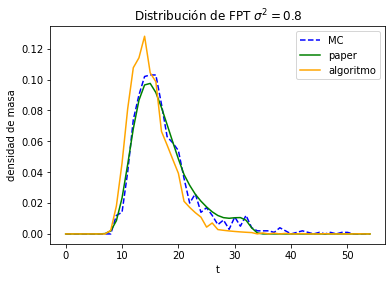

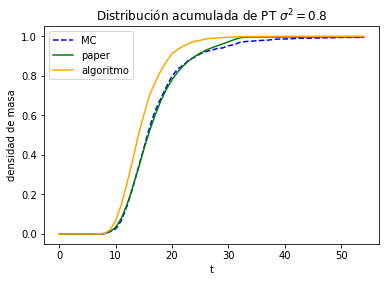

In [59]:
### CALCULO SIMPLE DE PROBABILIDAD PARA FPT ###
P_h = np.zeros((N,))
P_f = np.zeros((N,))
P = np.zeros((N + 1,))

P_h[0] = 1
P_f[0] = 0

for i in range(1,N):
    P_f[i] = norm.cdf((E[i] - u) / np.sqrt(Var[i]))
    P_h[i] = (1 - P_f[i - 1]) * P_h[i - 1]
    P[i] = P_f[i] * P_h[i]
P[len(P) - 1] = 1 - np.sum(P[: len(P) - 1])

### CALCULO DE FORMA MATRICIAL DE LA DISTRIBUCION DE PROBABILIDAD DE ACUERDO A PAPER
# q = np.matmul(np.linalg.inv(theta), A)

## calculo de q de forma recursiva
q = np.zeros((N,))
for i in range(k):
    aux = 0
    for j in range(i):
        aux += theta[i,j] * q[j]
    q[i] = A[i] - aux
    if q[i] < 0: q[i] = 0

print(np.sum(q))

plt.plot(histogram_MC, 'b--', label='MC')
plt.plot(np.array(range(len(q))), q, label='paper', color='green')
plt.plot(fpt / np.sum(fpt), label='algoritmo', color='orange')
plt.xlabel('t')
# plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(q), color='r', label='FPT proceso')
# plt.plot(P, 'go', label='simple prediction')
plt.ylabel('densidad de masa')
plt.title('Distribución de FPT $\sigma^2 =${}'.format(sigma))
plt.legend(loc='best')
plt.show()

# calculo de densidades acumuladas
a_MC = np.zeros((N,))
a_paper = np.zeros((N,))
a_filtro = np.zeros((N,))

a_MC[0] = histogram_MC[0] / np.sum(histogram_MC)
a_paper[0] = q[0]
a_filtro[0] = fpt[0] / np.sum(fpt)

for i in range(1,N):
    a_MC[i] = a_MC[i - 1] + histogram_MC[i]
    a_paper[i] = a_paper[i - 1] + q[i]
    a_filtro[i] = a_filtro[i - 1] + fpt[i] / np.sum(fpt)

plt.plot(a_MC, 'b--', label='MC')
plt.plot(np.array(range(len(q))), a_paper, label='paper', color='green')
plt.plot(a_filtro, label='algoritmo', color='orange')
plt.xlabel('t')
# plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(q), color='r', label='FPT proceso')
plt.ylabel('densidad de masa')
plt.title('Distribución acumulada de PT $\sigma^2 =${}'.format(sigma))
plt.legend(loc='best')
plt.show()

